## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# DEPENDENCIES INSTALLATION
# ============================================================================

!pip install jax jaxlib optax flax pandas numpy matplotlib seaborn scikit-learn optuna -q

print("✓ All dependencies installed")

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


✓ All dependencies installed


In [2]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import time
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# JAX ecosystem
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from flax import linen as nn
from flax.training import train_state

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score,
    classification_report,
    accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# Check JAX device
print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")
print(f"Default backend: {jax.default_backend()}")


JAX version: 0.5.2
Available devices: [CudaDevice(id=0), CudaDevice(id=1)]
Default backend: gpu


In [3]:
# ============================================================================
# CONFIGURATION - TRULY RANDOM SEED
# ============================================================================

RANDOM_SEED = int(time.time() * 1000) % (2**31)
np.random.seed(RANDOM_SEED)

print(f"\n✓ Using TRULY RANDOM seed: {RANDOM_SEED}")
print(f"  (Seed generated from current time, not fixed)")

PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']
NUM_CLASSES = len(PARTICLE_NAMES)

# ============================================================================
# CONFIGURATION - 3 MOMENTUM RANGES + MODEL TYPES (NO OPTUNA)
# ============================================================================

MODEL_TYPES = ['JAX_SimpleNN', 'JAX_DNN']

# 3 momentum ranges
MOMENTUM_RANGES = [
    {'min': 0.1, 'max': 999, 'name': 'Full Spectrum (0.1-∞ GeV/c)', 'key': 'full'},
    {'min': 0.7, 'max': 1.5, 'name': '0.7-1.5 GeV/c (Critical)', 'key': '0.7-1.5'},
    {'min': 1.0, 'max': 3.0, 'name': '1-3 GeV/c (Intermediate)', 'key': '1-3'}
]

# ============================================================================
# DIRECTORIES
# ============================================================================

BASE_DIR = '/kaggle/working'
SAVE_DIR = os.path.join(BASE_DIR, 'trained_models')
INPUT_DIR = '/kaggle/input/jax-models'

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"\n✓ Configuration loaded")
print(f"  Model types: {MODEL_TYPES}")
print(f"  NO Optuna - using fixed hyperparameters")
print(f"  Momentum ranges: {len(MOMENTUM_RANGES)}")
print(f"  Total models to train: {len(MODEL_TYPES) * len(MOMENTUM_RANGES)} = 6 models")
print(f"  Save directory: {SAVE_DIR}")
print(f"  Input directory: {INPUT_DIR}")

all_results_by_model_and_range = {}

# ============================================================================
# HELPER FUNCTIONS FOR SAVING/LOADING INDIVIDUAL MODELS
# ============================================================================

def get_model_filename(momentum_key, model_type):
    """Generate filename for individual model (no Optuna mode)"""
    return f"{momentum_key}_{model_type}.pkl"

def save_single_model(momentum_key, model_type, results):
    """Save a single model's results"""
    filename = get_model_filename(momentum_key, model_type)
    filepath = os.path.join(SAVE_DIR, filename)
    
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(results, f)
        file_size_kb = os.path.getsize(filepath) / 1024
        print(f"  ✓ Saved: {filename} ({file_size_kb:.1f} KB)")
        return True
    except Exception as e:
        print(f"  ✗ Error saving {filename}: {e}")
        return False

def load_single_model(momentum_key, model_type, source='working'):
    """Load a single model's results"""
    filename = get_model_filename(momentum_key, model_type)
    
    if source == 'working':
        filepath = os.path.join(SAVE_DIR, filename)
    else:
        filepath = os.path.join(INPUT_DIR, filename)
    
    if os.path.exists(filepath):
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            return results, filepath
        except Exception as e:
            print(f"  ✗ Error loading {filename}: {e}")
            return None, None
    
    return None, None

print("\n✓ Section 1 COMPLETE")



✓ Using TRULY RANDOM seed: 496420974
  (Seed generated from current time, not fixed)

✓ Configuration loaded
  Model types: ['JAX_SimpleNN', 'JAX_DNN']
  NO Optuna - using fixed hyperparameters
  Momentum ranges: 3
  Total models to train: 6 = 6 models
  Save directory: /kaggle/working/trained_models
  Input directory: /kaggle/input/jax-models

✓ Section 1 COMPLETE


## Section 2: Data Loading & Preprocessing

In [4]:
# ============================================================================
# SECTION 2: DATA LOADING & PREPROCESSING (UPDATED FOR FEATURE SET EMBEDDING + ATTENTION (FSE))
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 2: DATA LOADING & PREPROCESSING")
print(f"{'#'*80}")

CSV_PATH = '/kaggle/input/pid-features/pid_features_large.csv'

print("\nLoading data (shared for all model analyses)...")
df_iter = pd.read_csv(CSV_PATH, dtype='float32', chunksize=500000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)

print(f"✓ Loaded: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

def preprocess_momentum_range(df, momentum_range):
    """
    Enhanced preprocessing with detector masks for FSE
    """
    print(f"\n{'─'*80}")
    print(f"Preprocessing: {momentum_range['name']}")
    print(f"{'─'*80}")
    
    df_filtered = df[(df['p'] >= momentum_range['min']) & 
                     (df['p'] < momentum_range['max'])].copy()
    
    print(f"  Samples after momentum filter: {len(df_filtered):,}")
    
    training_features = [
        'pt', 'eta', 'phi',
        'tpc_signal', 
        'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
        'tof_beta',
        'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
        'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
        'dca_xy', 'dca_z',
        'has_tpc', 'has_tof'
    ]
    
    # Missing value handling (same as before)
    print("\n  Missing value analysis:")
    missing_before = df_filtered[training_features].isnull().sum()
    total_missing = missing_before.sum()
    
    if total_missing > 0:
        print(f"    Total missing values before handling: {total_missing:,}")
        for feat in training_features:
            missing_count = missing_before[feat]
            if missing_count > 0:
                missing_pct = (missing_count / len(df_filtered)) * 100
                print(f"      {feat:25s}: {missing_count:6,} ({missing_pct:.2f}%)")
    
    tof_features = ['tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el']
    for feat in tof_features:
        if feat in df_filtered.columns:
            if feat == 'tof_beta':
                df_filtered[feat].fillna(0.0, inplace=True)
            else:
                df_filtered[feat].fillna(999.0, inplace=True)
    
    tpc_features = ['tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el']
    for feat in tpc_features:
        if feat in df_filtered.columns:
            if feat == 'tpc_signal':
                df_filtered[feat].fillna(0.0, inplace=True)
            else:
                df_filtered[feat].fillna(999.0, inplace=True)
    
    bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el']
    for feat in bayes_features:
        if feat in df_filtered.columns:
            df_filtered[feat].fillna(0.25, inplace=True)
    
    kinematic_features = ['pt', 'eta', 'phi', 'dca_xy', 'dca_z']
    for feat in kinematic_features:
        if feat in df_filtered.columns:
            median_val = df_filtered[feat].median()
            df_filtered[feat].fillna(median_val, inplace=True)
    
    df_filtered['has_tpc'].fillna(0, inplace=True)
    df_filtered['has_tof'].fillna(0, inplace=True)
    
    missing_after = df_filtered[training_features].isnull().sum().sum()
    print(f"\n    Total missing values after handling: {missing_after}")
    
    if missing_after > 0:
        print("    ⚠ Warning: Some missing values remain, dropping rows...")
        df_filtered.dropna(subset=training_features, inplace=True)
        print(f"    Samples after dropping missing: {len(df_filtered):,}")
    
    # ========================================================================
    # NEW: CREATE DETECTOR GROUP MASKS FOR FSE
    # ========================================================================
    
    detector_groups = {
        'tpc': ['tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el'],
        'tof': ['tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el'],
        'bayes': ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el'],
        'kinematics': ['pt', 'eta', 'phi', 'dca_xy', 'dca_z']
    }
    
    group_names = list(detector_groups.keys())
    group_masks_data = []
    
    for g in group_names:
        if g == 'tpc':
            group_masks_data.append(df_filtered['has_tpc'].values.astype('float32'))
        elif g == 'tof':
            group_masks_data.append(df_filtered['has_tof'].values.astype('float32'))
        else:
            group_masks_data.append(np.ones(len(df_filtered), dtype='float32'))
    
    group_masks = np.stack(group_masks_data, axis=1)  # (N, num_groups)
    
    print(f"\n  ✓ Detector group masks created:")
    print(f"    Groups: {group_names}")
    print(f"    Mask shape: {group_masks.shape}")
    
    # Continue with normal preprocessing
    X = df_filtered[training_features].values
    y = df_filtered['mc_pdg'].values
    
    def pdg_to_species(pdg):
        ap = abs(int(pdg))
        if ap == 211:
            return 0
        elif ap == 321:
            return 1
        elif ap == 2212:
            return 2
        elif ap == 11:
            return 3
        else:
            return -1
    
    y = np.array([pdg_to_species(pdg) for pdg in y])
    valid_mask = y >= 0
    X = X[valid_mask]
    y = y[valid_mask]
    group_masks = group_masks[valid_mask]
    
    print(f"\n  Final dataset shape: {X.shape}")
    print(f"  Class distribution:")
    for i, particle in enumerate(PARTICLE_NAMES):
        count = np.sum(y == i)
        pct = (count / len(y)) * 100
        print(f"    {particle:10s}: {count:6,} ({pct:5.2f}%)")
    
    X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
        X, y, group_masks, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n  Train samples: {len(X_train):,}")
    print(f"  Test samples:  {len(X_test):,}")
    
    return (X_train_scaled, X_test_scaled, y_train, y_test, scaler, training_features,
            masks_train, masks_test, group_names)

print(f"\n{'='*80}")
print("✓ SECTION 2 COMPLETE: Data loaded with detector group masks")
print(f"{'='*80}")



################################################################################
SECTION 2: DATA LOADING & PREPROCESSING
################################################################################

Loading data (shared for all model analyses)...
✓ Loaded: (4729393, 37)
  Rows: 4,729,393
  Columns: 37

✓ SECTION 2 COMPLETE: Data loaded with detector group masks


## Section 3: Training Steps with BatchNorm Support

In [9]:
# ============================================================================
# SECTION 3: JAX MODEL ARCHITECTURES & TRAINING UTILITIES (FOCAL LOSS + FSE)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES")
print(f"{'#'*80}")

# ============================================================================
# FOCAL LOSS FUNCTION - FOR ALL MODELS
# ============================================================================

def focal_loss(logits, labels, class_weights=None, alpha=0.25, gamma=2.0):
    """
    Focal loss for multi-class classification.
    Focuses training on hard negatives and reduces easy negative weight.
    
    Args:
        logits: (batch, num_classes)
        labels: (batch,) - class indices
        class_weights: optional (num_classes,) for class balancing
        alpha: focusing parameter (default 0.25)
        gamma: exponent parameter (default 2.0)
    
    Returns:
        scalar loss
    """
    probs = jax.nn.softmax(logits, axis=-1)
    # p_t = probability of the true class
    p_t = probs[jnp.arange(labels.shape[0]), labels]
    ce_loss = -jnp.log(p_t + 1e-7)
    
    # Apply class weights if provided
    if class_weights is not None:
        w = class_weights[labels]
    else:
        w = 1.0
    
    # Focal weight: down-weights easy examples
    focal_weight = alpha * (1.0 - p_t) ** gamma
    loss = jnp.mean(w * focal_weight * ce_loss)
    return loss

print("✓ Focal loss function defined")

# ============================================================================
# JAX MODEL ARCHITECTURES
# ============================================================================

class JAX_SimpleNN(nn.Module):
    """Simple feedforward neural network"""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x

class JAX_DNN(nn.Module):
    """Deeper neural network with batch normalisation"""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.BatchNorm(use_running_average=not training)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x

# FSE + ATTENTION MODEL
class JAX_FSE_Attention(nn.Module):
    """
    Feature Set Embedding with Multi-Head Attention
    Handles missing detector information elegantly via masks
    """
    hidden_dim: int = 64
    num_heads: int = 4
    num_classes: int = 4
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, group_mask, training: bool = False):
        """
        Args:
            x: (batch, num_features) - flattened features
            group_mask: (batch, num_groups) - 1 if detector group present, 0 otherwise
            training: boolean for dropout
        """
        batch_size = x.shape[0]
        num_groups = group_mask.shape[1]
        
        # Project features to per-group embeddings
        feat_proj = nn.Dense(self.hidden_dim * num_groups)(x)
        feat_proj = feat_proj.reshape((batch_size, num_groups, self.hidden_dim))
        
        # Mask missing detector groups
        feat_proj = feat_proj * group_mask[:, :, None]  # (B, G, D)
        
        # Reshape mask for attention
        # MultiHeadDotProductAttention expects mask shape (B, 1, T, S) or (B, T, S)
        # We need to reshape group_mask from (B, G) to (B, 1, 1, G) for broadcasting
        attn_mask = group_mask[:, None, None, :]  # (B, 1, 1, G)
        
        # Self-attention over detector groups
        feat_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads
        )(feat_proj, feat_proj, mask=attn_mask)  # (B, G, D)
        
        # Layer norm after attention
        feat_attn = nn.LayerNorm()(feat_attn)
        
        # Gated fusion: gate each detector group
        gates = nn.Dense(self.hidden_dim)(feat_attn)
        gates = nn.sigmoid(gates)
        feat_gated = feat_attn * gates
        
        # Masked pooling: mean over available detector groups
        denom = jnp.clip(jnp.sum(group_mask, axis=1, keepdims=True), a_min=1.0)
        pooled = jnp.sum(feat_gated * group_mask[:, :, None], axis=1) / denom  # (B, D)
        
        # Classification head
        x = nn.Dense(128)(pooled)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        
        return x


print("✓ Model architectures defined:")
print("  - JAX_SimpleNN: Simple feedforward network")
print("  - JAX_DNN: Deeper network with batch normalisation")
print("  - JAX_FSE_Attention: Feature Set Embedding + attention (handles missing data)")

# ============================================================================
# TRAINING FUNCTIONS - SIMPLE (NO BATCHNORM)
# ============================================================================

@jit
def train_step_simple(state, batch_x, batch_y, rng, class_weights):
    """Training step for models WITHOUT BatchNorm, using Focal Loss"""
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params}, batch_x, training=True, rngs={'dropout': rng}
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights,
                          alpha=0.25, gamma=2.0)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def eval_step_simple(state, batch_x, batch_y):
    """Evaluation step for models WITHOUT BatchNorm"""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits

print("✓ Simple training utilities defined (for JAX_SimpleNN and JAX_FSE_Attention)")

# ============================================================================
# TRAINING FUNCTIONS - WITH BATCHNORM
# ============================================================================

@jit
def train_step_batchnorm(state, batch_x, batch_y, rng, class_weights):
    """Training step for models WITH BatchNorm, using Focal Loss"""
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(
            variables, batch_x, training=True, 
            rngs={'dropout': rng}, mutable=['batch_stats']
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights,
                          alpha=0.25, gamma=2.0)
        return loss, new_model_state
    
    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss

@jit
def eval_step_batchnorm(state, batch_x, batch_y):
    """Evaluation step for models WITH BatchNorm"""
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits

print("✓ BatchNorm training utilities defined (for JAX_DNN)")

# TRAINING FUNCTIONS FOR FSE+ATTENTION

@jit
def train_step_fse(state, batch_x, batch_mask, batch_y, rng, class_weights):
    """Training step for FSE+Attention (no BatchNorm), using Focal Loss"""
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params}, batch_x, batch_mask, training=True, rngs={'dropout': rng}
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights,
                          alpha=0.25, gamma=2.0)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def eval_step_fse(state, batch_x, batch_mask, batch_y):
    """Evaluation step for FSE+Attention"""
    logits = state.apply_fn({'params': state.params}, batch_x, batch_mask, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits

print("✓ FSE+Attention training utilities defined")

# ============================================================================
# BATCH EVALUATION UTILITIES
# ============================================================================

def batch_evaluate_simple(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for models WITHOUT BatchNorm"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_simple(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits

def batch_evaluate_batchnorm(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for models WITH BatchNorm"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_batchnorm(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits

# BATCH EVALUATE FOR FSE

def batch_evaluate_fse(state, X_data, mask_data, y_data, batch_size=1024):
    """Batch evaluation for FSE+Attention"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_mask = mask_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_fse(state, batch_x, batch_mask, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits

print("✓ Batch evaluation utilities defined")

# ============================================================================
# EXTENDED TRAINSTATE FOR BATCHNORM
# ============================================================================

class TrainStateWithBatchStats(train_state.TrainState):
    """Extended TrainState that includes batch_stats for BatchNorm"""
    batch_stats: any = None

print("✓ Extended TrainState defined for BatchNorm models")

# ============================================================================
# FIXED HYPERPARAMETERS (NO OPTUNA)
# ============================================================================

# UPDATED MODEL LIST
MODEL_TYPES = ['JAX_SimpleNN', 'JAX_DNN', 'JAX_FSE_Attention']

HYPERPARAMETERS = {
    'JAX_SimpleNN': {
        'hidden_dims': [512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 10
    },
    'JAX_DNN': {
        'hidden_dims': [1024, 512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.00005,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 10
    },
    'JAX_FSE_Attention': {
        'hidden_dim': 64,
        'num_heads': 4,
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 10
    }
}

print("\n✓ Fixed Hyperparameters (No Optuna):")
for model_type, params in HYPERPARAMETERS.items():
    print(f"\n  {model_type}:")
    for key, val in params.items():
        print(f"    {key:20s}: {val}")

print(f"\n{'='*80}")
print("✓ SECTION 3 COMPLETE: Models, Focal Loss, & training utilities ready")
print(f"  Model types: {MODEL_TYPES}")
print(f"  Training loss: Focal Loss (α=0.25, γ=2.0) for all models")
print(f"{'='*80}")



################################################################################
SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES
################################################################################
✓ Focal loss function defined
✓ Model architectures defined:
  - JAX_SimpleNN: Simple feedforward network
  - JAX_DNN: Deeper network with batch normalisation
  - JAX_FSE_Attention: Feature Set Embedding + attention (handles missing data)
✓ Simple training utilities defined (for JAX_SimpleNN and JAX_FSE_Attention)
✓ BatchNorm training utilities defined (for JAX_DNN)
✓ FSE+Attention training utilities defined
✓ Batch evaluation utilities defined
✓ Extended TrainState defined for BatchNorm models

✓ Fixed Hyperparameters (No Optuna):

  JAX_SimpleNN:
    hidden_dims         : [512, 256, 128, 64]
    dropout_rate        : 0.5
    learning_rate       : 0.0001
    batch_size          : 256
    num_epochs          : 100
    patience            : 10

  JAX_DNN:
    hidden_dims       

## Section 4: Run Analyses

### Section 4A: Train JAX_SimpleNN

In [6]:
# ============================================================================
# SECTION 4A: TRAIN JAX_SIMPLENN MODEL (WITH FOCAL LOSS)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4A: TRAINING JAX_SIMPLENN MODEL")
print(f"{'#'*80}")

# ============================================================================
# FORCE_TRAINING FLAGS FOR SIMPLENN (3 RANGES - NO OPTUNA)
# ============================================================================

FORCE_TRAINING_SIMPLENN = {
    'full': True,
    '0.7-1.5': True,
    '1-3': True,
}

print(f"\n{'='*80}")
print("SIMPLENN FORCE_TRAINING FLAGS:")
print(f"{'='*80}")
for mr_key, flag in FORCE_TRAINING_SIMPLENN.items():
    print(f"  {mr_key:10s}: {flag}")
print(f"{'='*80}\n")

# ============================================================================
# TRAIN/LOAD MODELS
# ============================================================================

all_results_by_model_and_range = {}

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    all_results_by_model_and_range[mr_key] = {}
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Preprocess data once for this momentum range
    (X_train_scaled, X_test_scaled, y_train, y_test, scaler, features,
     masks_train, masks_test, group_names) = preprocess_momentum_range(df, momentum_range)
    
    # Store preprocessing info (including masks for FSE)
    all_results_by_model_and_range[mr_key]['preprocessing'] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'features': features,
        'masks_train': masks_train,
        'masks_test': masks_test,
        'group_names': group_names
    }
    
    all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = {}
    
    # ========================================================================
    # TRAIN JAX_SIMPLENN (SINGLE MODE - NO OPTUNA, WITH FOCAL LOSS)
    # ========================================================================
    
    print(f"\n{'*'*80}")
    print(f"JAX_SimpleNN Training (Focal Loss)")
    print(f"{'*'*80}")
    
    # Check for existing model file
    force_flag = FORCE_TRAINING_SIMPLENN[mr_key]
    if not force_flag:
        loaded, _ = load_single_model(mr_key, 'JAX_SimpleNN')
    else:
        loaded = None
    
    if loaded is not None:
        print(f"✓ Loaded: {mr_key}/JAX_SimpleNN (skipped training)")
        all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = loaded
    else:
        print("Training from scratch...")
        
        # Get fixed hyperparameters
        params = HYPERPARAMETERS['JAX_SimpleNN']
        
        print(f"✓ Using fixed parameters:")
        print(f"  Hidden dims:   {params['hidden_dims']}")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Dropout rate:  {params['dropout_rate']}")
        print(f"  Patience:      {params['patience']}")
        print(f"  Loss function: Focal Loss (α=0.25, γ=2.0)")
        
        # Convert to JAX
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        
        # Class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        
        print(f"\nClass weights:")
        for i, weight in enumerate(class_weights):
            print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")
        
        # Initialise model
        key = random.PRNGKey(RANDOM_SEED)
        model = JAX_SimpleNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        model_params = model.init(key, dummy_input, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        # Training loop
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key
        
        print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...")
        
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, loss = train_step_simple(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            
            # Batched validation to avoid OOM
            val_acc, _ = batch_evaluate_simple(state, X_test_jax, y_test_jax, batch_size=1024)
            val_accuracies.append(float(val_acc))
            
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1} (patience={params['patience']})")
                    break
        
        state = state.replace(params=best_params_state)
        
        # ====================================================================
        # FINAL EVALUATION (WITH BATCHING TO AVOID OOM)
        # ====================================================================
        
        print(f"\nFinal Evaluation (batched to avoid memory issues)...")
        
        # Use batch_evaluate instead of eval_step
        train_acc, train_logits = batch_evaluate_simple(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = batch_evaluate_simple(state, X_test_jax, y_test_jax, batch_size=1024)
        
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        
        print(f"\nRESULTS:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  Best Val Acc:   {best_val_acc:.4f}")
        
        # Store results
        results = {
            'model_type': 'JAX_SimpleNN',
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        
        all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = results
        save_single_model(mr_key, 'JAX_SimpleNN', results)

print(f"\n{'='*80}")
print("✓ SECTION 4A COMPLETE: JAX_SimpleNN Trained with Focal Loss")
print(f"{'='*80}")
print(f"\nModels trained: JAX_SimpleNN × 3 ranges = 3 models")



################################################################################
SECTION 4A: TRAINING JAX_SIMPLENN MODEL
################################################################################

SIMPLENN FORCE_TRAINING FLAGS:
  full      : True
  0.7-1.5   : True
  1-3       : True


MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

────────────────────────────────────────────────────────────────────────────────
Preprocessing: Full Spectrum (0.1-∞ GeV/c)
────────────────────────────────────────────────────────────────────────────────
  Samples after momentum filter: 4,729,392

  Missing value analysis:

    Total missing values after handling: 0

  ✓ Detector group masks created:
    Groups: ['tpc', 'tof', 'bayes', 'kinematics']
    Mask shape: (4729392, 4)

  Final dataset shape: (4163954, 21)
  Class distribution:
    Pion      : 2,879,564 (69.15%)
    Kaon      : 197,625 ( 4.75%)
    Proton    : 517,809 (12.44%)
    Electron  : 568,956 (13.66%)

  Train samples: 3,331,163
  Test

### Section 4B: Train JAX_DNN

In [7]:
# ============================================================================
# SECTION 4B: TRAIN JAX_DNN MODEL (WITH FOCAL LOSS + BATCHNORM)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4B: TRAINING JAX_DNN MODEL")
print(f"{'#'*80}")

# ============================================================================
# FORCE_TRAINING FLAGS FOR DNN (3 RANGES - NO OPTUNA)
# ============================================================================

FORCE_TRAINING_DNN = {
    'full': True,
    '0.7-1.5': True,
    '1-3': True,
}

print(f"\n{'='*80}")
print("DNN FORCE_TRAINING FLAGS:")
print(f"{'='*80}")
for mr_key, flag in FORCE_TRAINING_DNN.items():
    print(f"  {mr_key:10s}: {flag}")
print(f"{'='*80}\n")

# ============================================================================
# TRAIN/LOAD MODELS
# ============================================================================

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Get preprocessed data from Section 4A
    X_train_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_train_scaled']
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_train = all_results_by_model_and_range[mr_key]['preprocessing']['y_train']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    
    all_results_by_model_and_range[mr_key]['JAX_DNN'] = {}
    
    # ========================================================================
    # TRAIN JAX_DNN (SINGLE MODE - NO OPTUNA, WITH FOCAL LOSS)
    # ========================================================================
    
    print(f"\n{'*'*80}")
    print(f"JAX_DNN Training (Focal Loss + BatchNorm)")
    print(f"{'*'*80}")
    
    # Check for existing model file
    force_flag = FORCE_TRAINING_DNN[mr_key]
    if not force_flag:
        loaded, _ = load_single_model(mr_key, 'JAX_DNN')
    else:
        loaded = None
    
    if loaded is not None:
        print(f"✓ Loaded: {mr_key}/JAX_DNN (skipped training)")
        all_results_by_model_and_range[mr_key]['JAX_DNN'] = loaded
    else:
        print("Training from scratch...")
        
        # Get fixed hyperparameters
        params = HYPERPARAMETERS['JAX_DNN']
        
        print(f"✓ Using fixed parameters:")
        print(f"  Hidden dims:   {params['hidden_dims']}")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Dropout rate:  {params['dropout_rate']}")
        print(f"  Patience:      {params['patience']}")
        print(f"  Loss function: Focal Loss (α=0.25, γ=2.0)")
        
        # Convert to JAX
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        
        # Class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        
        print(f"\nClass weights:")
        for i, weight in enumerate(class_weights):
            print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")
        
        # ====================================================================
        # INITIALISE MODEL WITH BATCHNORM SUPPORT
        # ====================================================================
        
        print("\nInitialising JAX_DNN with BatchNorm...")
        
        key = random.PRNGKey(RANDOM_SEED + 2000)
        model = JAX_DNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        
        # Initialise model with batch_stats for BatchNorm
        variables = model.init(key, dummy_input, training=True)
        
        # Extract params and batch_stats
        model_params = variables['params']
        batch_stats = variables.get('batch_stats', {})
        
        # Create TrainState with batch_stats
        tx = optax.adam(params['learning_rate'])
        state = TrainStateWithBatchStats.create(
            apply_fn=model.apply,
            params=model_params,
            tx=tx,
            batch_stats=batch_stats
        )
        
        print(f"✓ Model initialised with batch_stats")
        
        # Training loop
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key
        
        print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...")
        
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                
                # Train with batch_stats support and focal loss
                state, loss = train_step_batchnorm(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            
            # Use batched validation to avoid OOM
            val_acc, _ = batch_evaluate_batchnorm(state, X_test_jax, y_test_jax, batch_size=1024)
            val_accuracies.append(float(val_acc))
            
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
                best_batch_stats = state.batch_stats
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1} (patience={params['patience']})")
                    break
        
        # Restore best parameters and batch_stats
        state = state.replace(params=best_params_state, batch_stats=best_batch_stats)
        
        # ====================================================================
        # FINAL EVALUATION (WITH BATCHING + BATCHNORM SUPPORT)
        # ====================================================================
        
        print(f"\nFinal Evaluation (batched to avoid memory issues)...")
        
        # Use batch_evaluate with batch_stats support
        train_acc, train_logits = batch_evaluate_batchnorm(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = batch_evaluate_batchnorm(state, X_test_jax, y_test_jax, batch_size=1024)
        
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        
        print(f"\nRESULTS:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  Best Val Acc:   {best_val_acc:.4f}")
        
        # Store results
        results = {
            'model_type': 'JAX_DNN',
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        
        all_results_by_model_and_range[mr_key]['JAX_DNN'] = results
        save_single_model(mr_key, 'JAX_DNN', results)

print(f"\n{'='*80}")
print("✓ SECTION 4B COMPLETE: JAX_DNN Trained with Focal Loss")
print(f"{'='*80}")
print(f"\nModels trained: JAX_DNN × 3 ranges = 3 models")



################################################################################
SECTION 4B: TRAINING JAX_DNN MODEL
################################################################################

DNN FORCE_TRAINING FLAGS:
  full      : True
  0.7-1.5   : True
  1-3       : True


MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

********************************************************************************
JAX_DNN Training (Focal Loss + BatchNorm)
********************************************************************************
Training from scratch...
✓ Using fixed parameters:
  Hidden dims:   [1024, 512, 256, 128, 64]
  Learning rate: 5e-05
  Dropout rate:  0.5
  Patience:      10
  Loss function: Focal Loss (α=0.25, γ=2.0)

Class weights:
  Pion      : 0.3615
  Kaon      : 5.2675
  Proton    : 2.0104
  Electron  : 1.8296

Initialising JAX_DNN with BatchNorm...
✓ Model initialised with batch_stats

Training (max 100 epochs, patience=10)...
Epoch   1/100 | Loss: 0.1651 | Val Acc: 0.276

### Section 4C: Train JAX_FSE_Attention

In [10]:
# ============================================================================
# SECTION 4C: TRAIN JAX_FSE_ATTENTION MODEL (NEW)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4C: TRAINING JAX_FSE_ATTENTION MODEL")
print(f"{'#'*80}")

# ============================================================================
# FORCE_TRAINING FLAGS FOR FSE (3 RANGES - NO OPTUNA)
# ============================================================================

FORCE_TRAINING_FSE = {
    'full': False,
    '0.7-1.5': False,
    '1-3': False,
}

print(f"\n{'='*80}")
print("FSE FORCE_TRAINING FLAGS:")
print(f"{'='*80}")
for mr_key, flag in FORCE_TRAINING_FSE.items():
    print(f"  {mr_key:10s}: {flag}")
print(f"{'='*80}\n")

# ============================================================================
# TRAIN/LOAD MODELS
# ============================================================================

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Get preprocessed data INCLUDING detector masks
    X_train_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_train_scaled']
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_train = all_results_by_model_and_range[mr_key]['preprocessing']['y_train']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    masks_train = all_results_by_model_and_range[mr_key]['preprocessing']['masks_train']
    masks_test = all_results_by_model_and_range[mr_key]['preprocessing']['masks_test']
    group_names = all_results_by_model_and_range[mr_key]['preprocessing']['group_names']
    
    all_results_by_model_and_range[mr_key]['JAX_FSE_Attention'] = {}
    
    # ========================================================================
    # TRAIN JAX_FSE_ATTENTION (FEATURE SET EMBEDDING + ATTENTION)
    # ========================================================================
    
    print(f"\n{'*'*80}")
    print(f"JAX_FSE_Attention Training (Focal Loss + Detector Masking)")
    print(f"{'*'*80}")
    
    # Check for existing model file
    force_flag = FORCE_TRAINING_FSE[mr_key]
    if not force_flag:
        loaded, _ = load_single_model(mr_key, 'JAX_FSE_Attention')
    else:
        loaded = None
    
    if loaded is not None:
        print(f"✓ Loaded: {mr_key}/JAX_FSE_Attention (skipped training)")
        all_results_by_model_and_range[mr_key]['JAX_FSE_Attention'] = loaded
    else:
        print("Training from scratch...")
        
        # Get fixed hyperparameters
        params = HYPERPARAMETERS['JAX_FSE_Attention']
        
        print(f"✓ Using fixed parameters:")
        print(f"  Hidden dim:    {params['hidden_dim']}")
        print(f"  Num heads:     {params['num_heads']}")
        print(f"  Learning rate: {params['learning_rate']}")
        print(f"  Dropout rate:  {params['dropout_rate']}")
        print(f"  Patience:      {params['patience']}")
        print(f"  Loss function: Focal Loss (α=0.25, γ=2.0)")
        print(f"  Detector groups: {group_names}")
        
        # Convert to JAX
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        masks_train_jax = jnp.array(masks_train, dtype=jnp.float32)
        masks_test_jax = jnp.array(masks_test, dtype=jnp.float32)
        
        # Class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        
        print(f"\nClass weights:")
        for i, weight in enumerate(class_weights):
            print(f"  {PARTICLE_NAMES[i]:10s}: {weight:.4f}")
        
        print(f"\nDetector availability:")
        for i, gname in enumerate(group_names):
            availability = np.mean(masks_train[:, i]) * 100
            print(f"  {gname:15s}: {availability:.1f}% of tracks")
        
        # Initialise model
        key = random.PRNGKey(RANDOM_SEED + 3000)
        model = JAX_FSE_Attention(
            hidden_dim=params['hidden_dim'],
            num_heads=params['num_heads'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        dummy_mask = jnp.ones((1, masks_train_jax.shape[1]))
        model_params = model.init(key, dummy_input, dummy_mask, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        print(f"✓ FSE+Attention model initialised")
        
        # Training loop
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key
        
        print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...")
        
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            masks_train_shuffled = masks_train_jax[perm]
            
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                batch_mask = masks_train_shuffled[start_idx:end_idx]
                
                # Train with FSE (uses masks + focal loss)
                state, loss = train_step_fse(state, batch_x, batch_mask, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            
            # Batched validation with masks
            val_acc, _ = batch_evaluate_fse(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
            val_accuracies.append(float(val_acc))
            
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1} (patience={params['patience']})")
                    break
        
        state = state.replace(params=best_params_state)
        
        # ====================================================================
        # FINAL EVALUATION
        # ====================================================================
        
        print(f"\nFinal Evaluation...")
        
        train_acc, train_logits = batch_evaluate_fse(state, X_train_jax, masks_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = batch_evaluate_fse(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
        
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        
        print(f"\nRESULTS:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")
        print(f"  Best Val Acc:   {best_val_acc:.4f}")
        
        # Store results
        results = {
            'model_type': 'JAX_FSE_Attention',
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        
        all_results_by_model_and_range[mr_key]['JAX_FSE_Attention'] = results
        save_single_model(mr_key, 'JAX_FSE_Attention', results)

print(f"\n{'='*80}")
print("✓ SECTION 4C COMPLETE: JAX_FSE_Attention Trained")
print(f"{'='*80}")
print(f"\nModels trained: JAX_FSE_Attention × 3 ranges = 3 models")
print(f"\nAll 9 JAX models now complete:")
print(f"  ✓ JAX_SimpleNN × 3 momentum ranges = 3 models")
print(f"  ✓ JAX_DNN × 3 momentum ranges = 3 models (with BatchNorm)")
print(f"  ✓ JAX_FSE_Attention × 3 momentum ranges = 3 models (with detector masking)")
print(f"\nAll models use Focal Loss (α=0.25, γ=2.0) for better class balance!")
print(f"\nReady for Section 5 comparison visualizations!")



################################################################################
SECTION 4C: TRAINING JAX_FSE_ATTENTION MODEL
################################################################################

FSE FORCE_TRAINING FLAGS:
  full      : False
  0.7-1.5   : False
  1-3       : False


MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

********************************************************************************
JAX_FSE_Attention Training (Focal Loss + Detector Masking)
********************************************************************************
Training from scratch...
✓ Using fixed parameters:
  Hidden dim:    64
  Num heads:     4
  Learning rate: 0.0001
  Dropout rate:  0.5
  Patience:      10
  Loss function: Focal Loss (α=0.25, γ=2.0)
  Detector groups: ['tpc', 'tof', 'bayes', 'kinematics']

Class weights:
  Pion      : 0.3615
  Kaon      : 5.2675
  Proton    : 2.0104
  Electron  : 1.8296

Detector availability:
  tpc            : 89.6% of tracks
  tof            : 8.5

## Section 5:  Comparison Visualisations

### Section 5A: Advanced Comparison Visualisations


################################################################################
SECTION 5A: COMPARISON VISUALIZATIONS
################################################################################

GENERATING ADVANCED COMPARISON VISUALIZATIONS


COMPREHENSIVE MODEL COMPARISON TABLE (9 Models)

             Momentum Range        Model Type Train Acc Test Acc Best Val Acc
Full Spectrum (0.1-∞ GeV/c)      JAX_SimpleNN    0.6139   0.6142       0.6142
Full Spectrum (0.1-∞ GeV/c)           JAX_DNN    0.6323   0.6326       0.6326
Full Spectrum (0.1-∞ GeV/c) JAX_FSE_Attention    0.6556   0.6556       0.6556
   0.7-1.5 GeV/c (Critical)      JAX_SimpleNN    0.6156   0.6150       0.6150
   0.7-1.5 GeV/c (Critical)           JAX_DNN    0.5900   0.5888       0.5888
   0.7-1.5 GeV/c (Critical) JAX_FSE_Attention    0.6308   0.6285       0.6285
   1-3 GeV/c (Intermediate)      JAX_SimpleNN    0.4937   0.4956       0.4956
   1-3 GeV/c (Intermediate)           JAX_DNN    0.4728   0.4740       0.4740

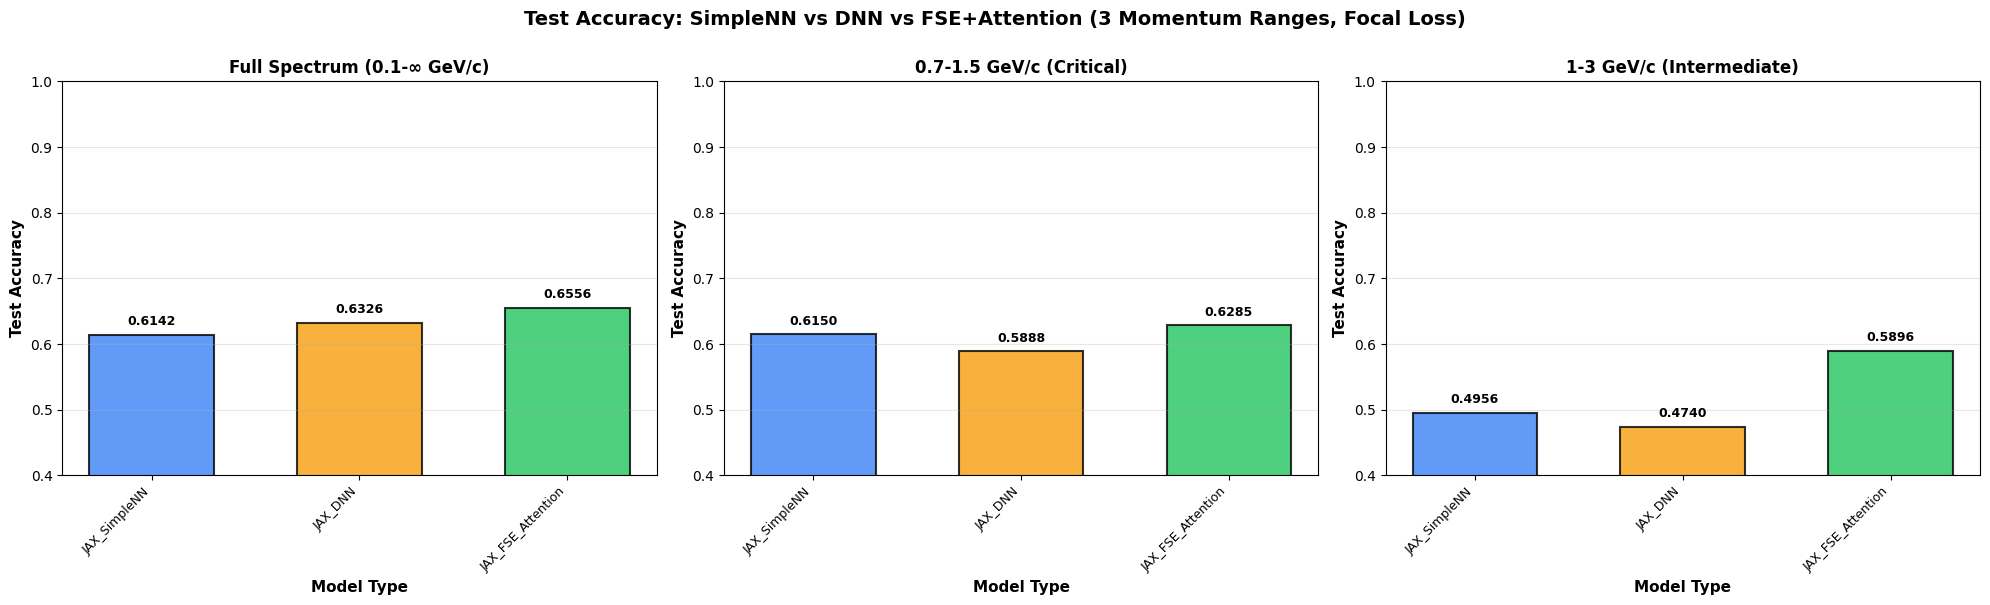

✓ Model accuracy comparison generated


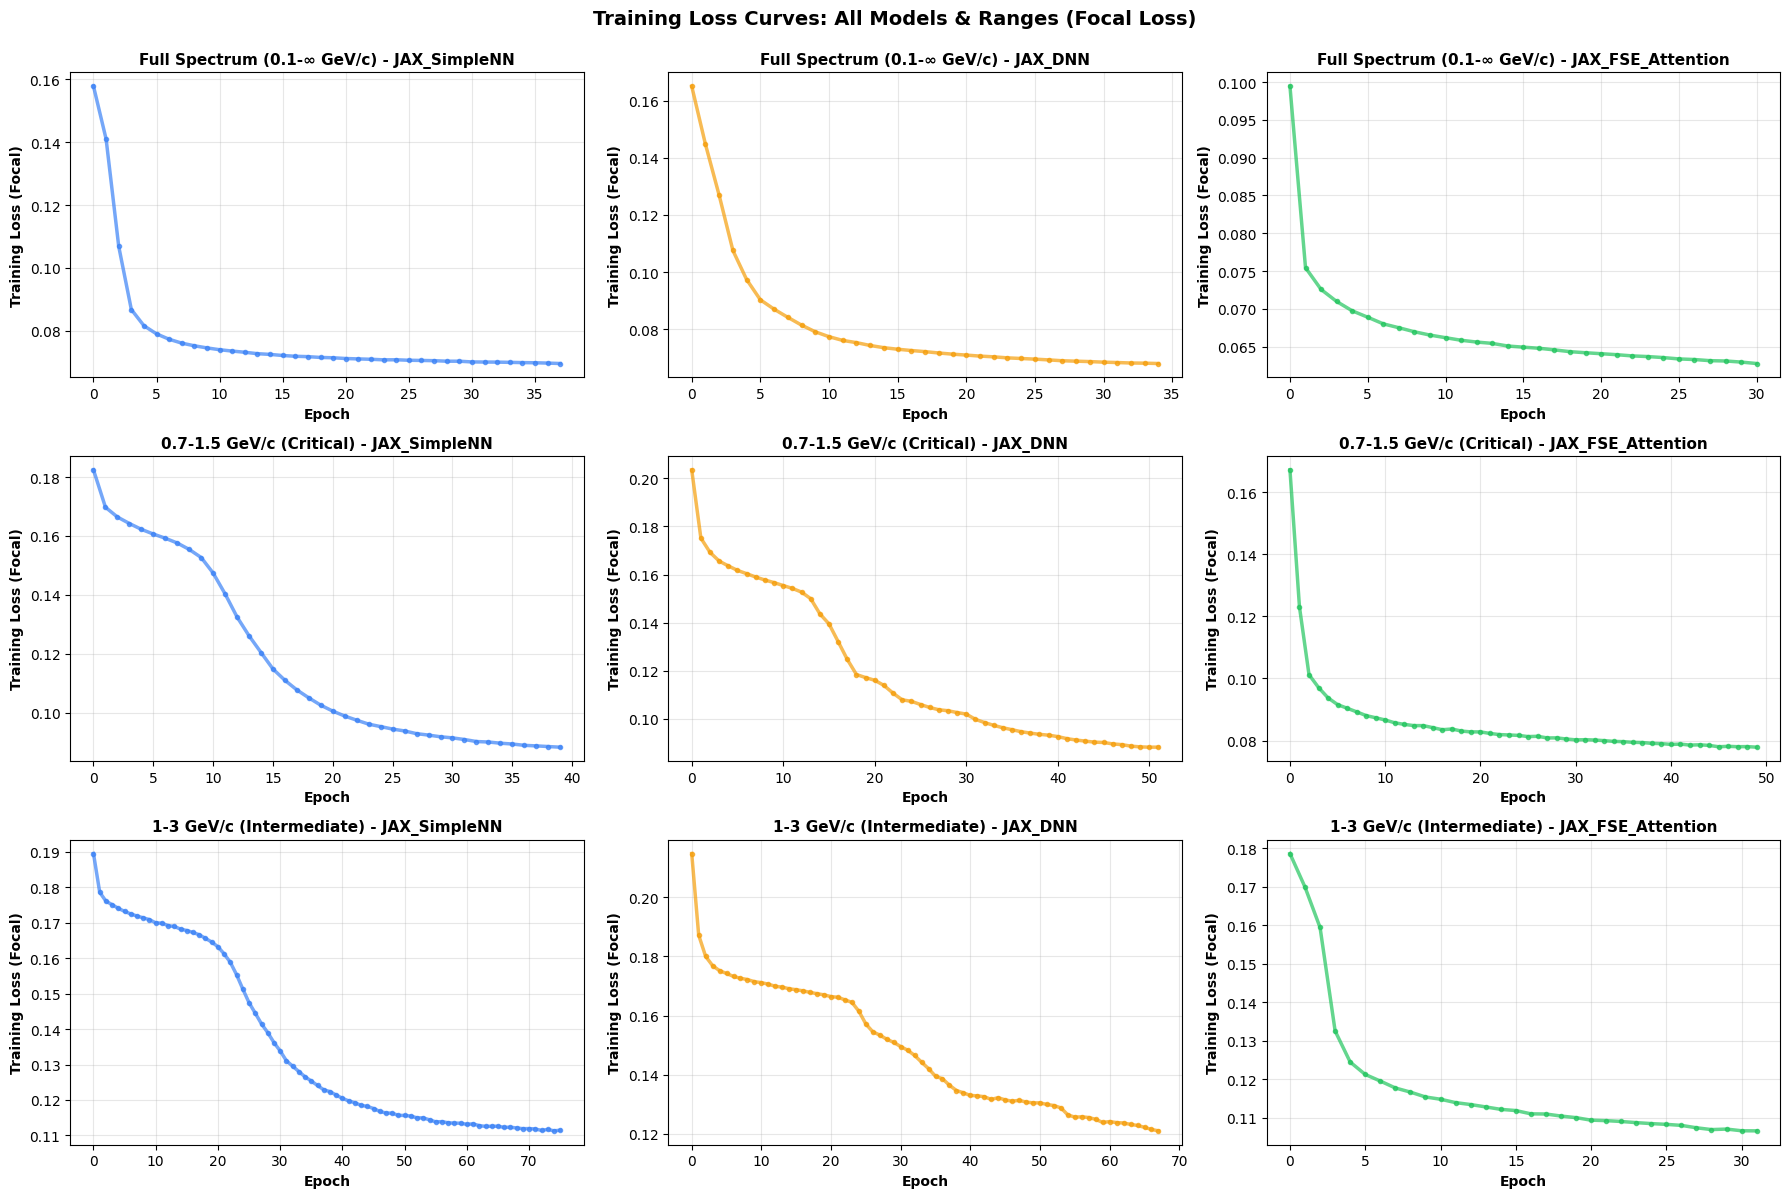

✓ Training curves comparison generated


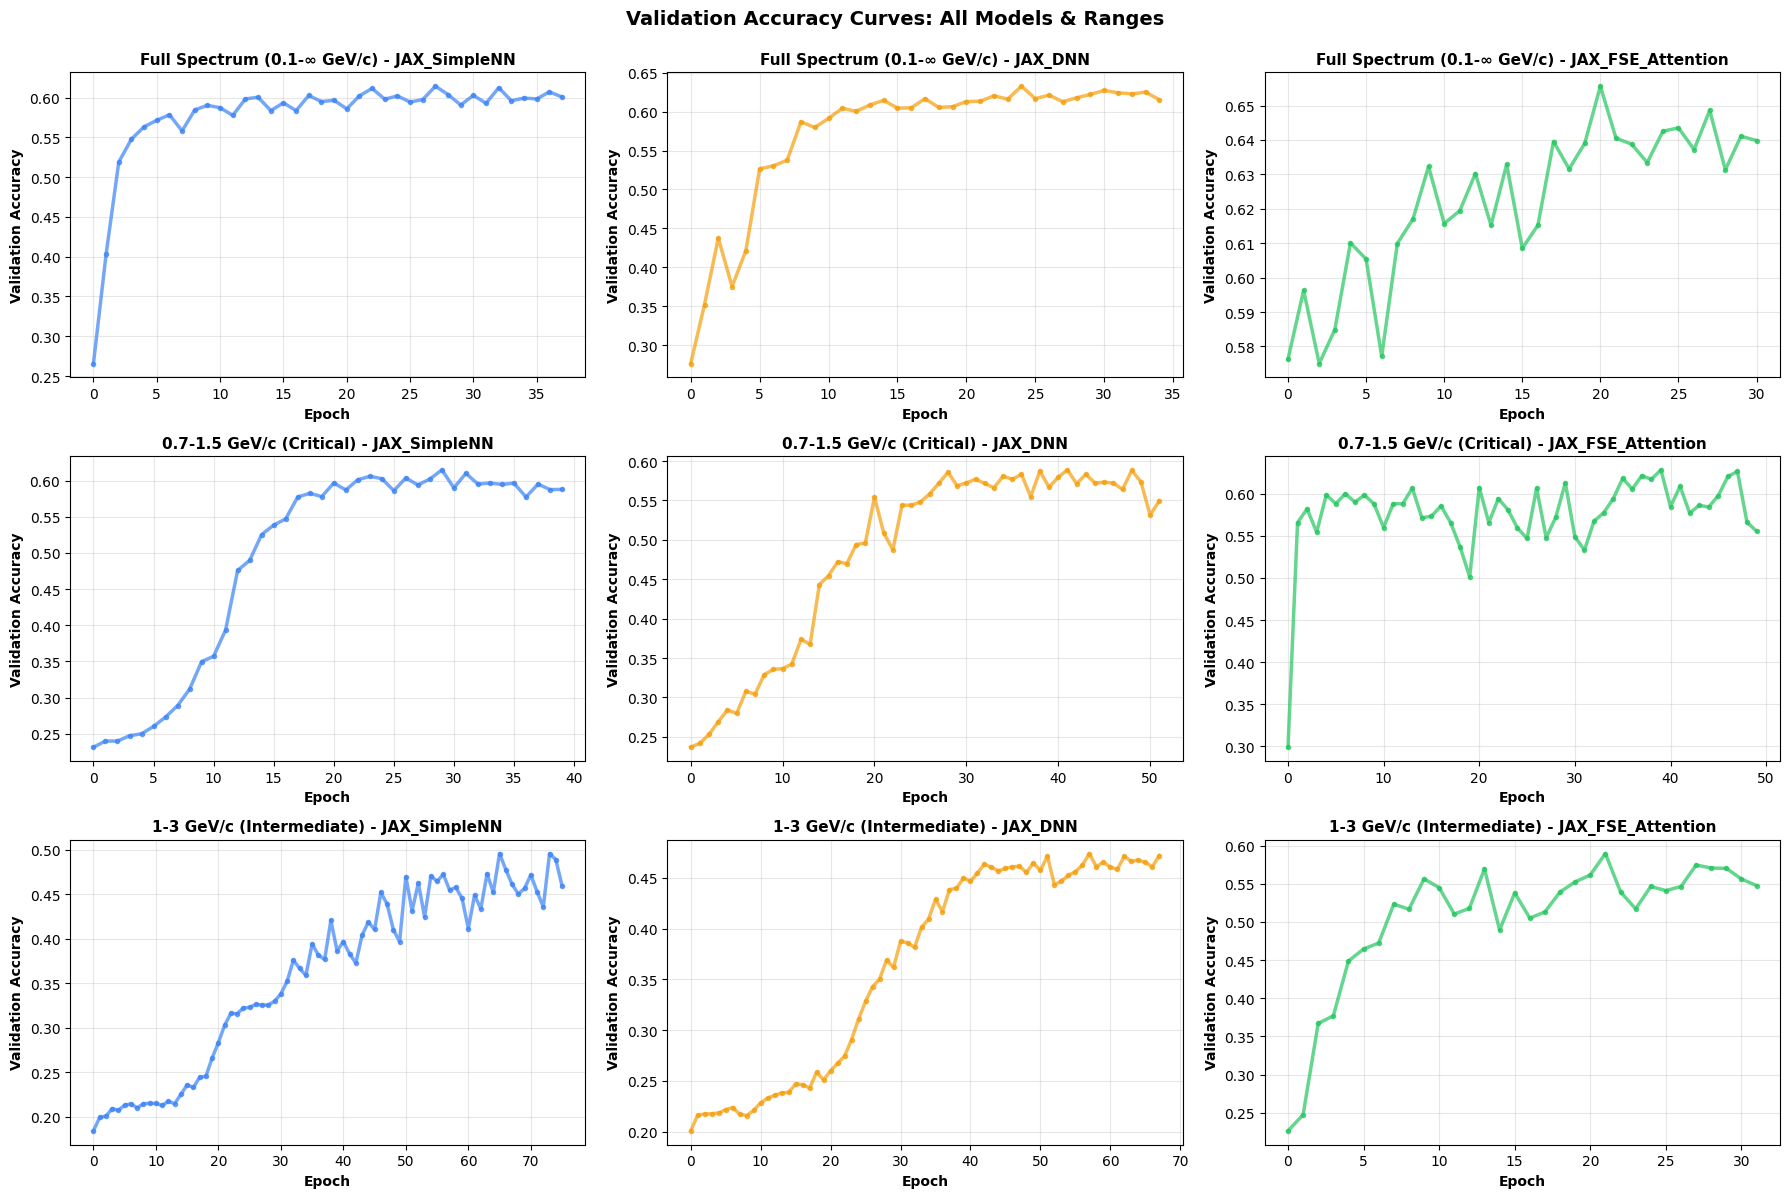

✓ Validation accuracy curves comparison generated


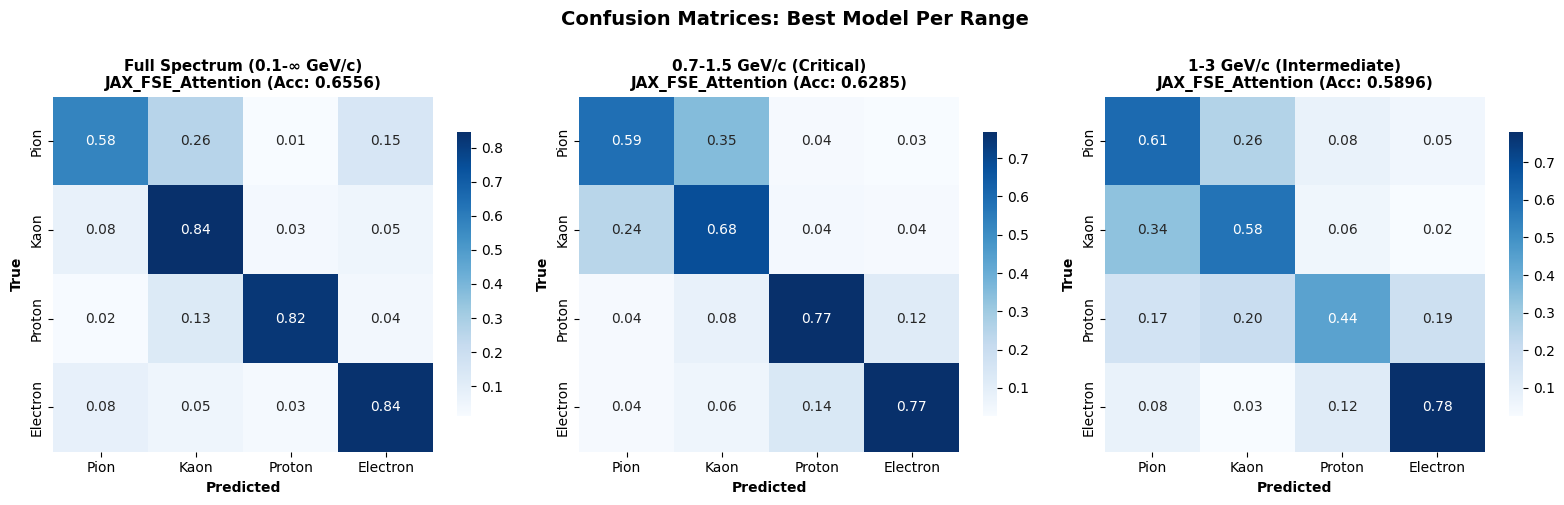

✓ Confusion matrices comparison generated


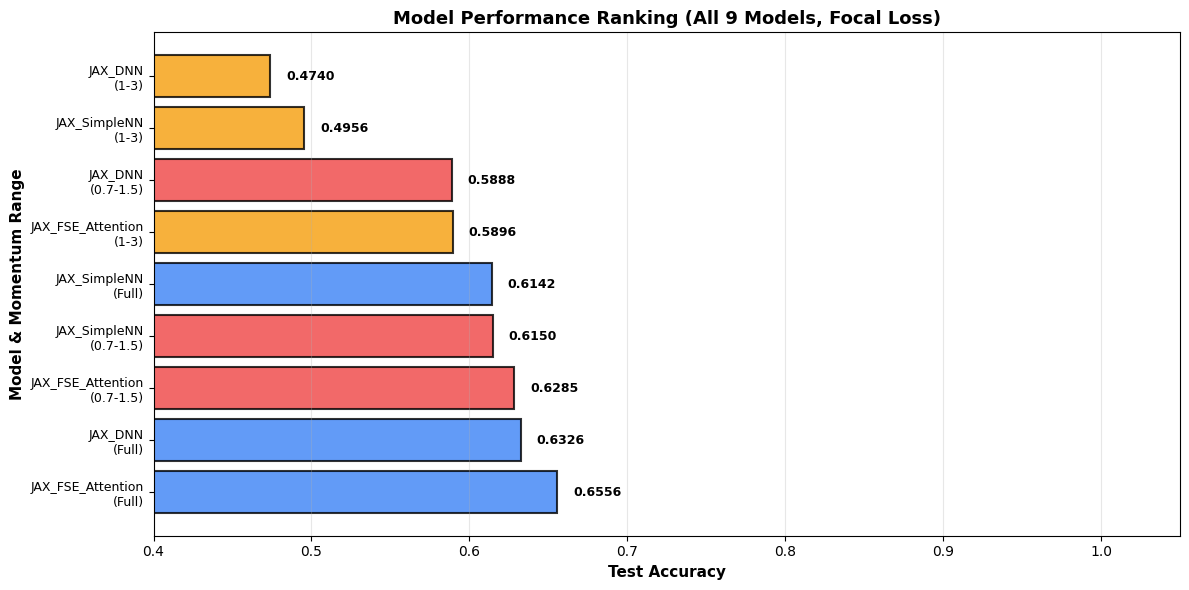

✓ Performance ranking generated

✓ SECTION 5A COMPLETE: Comparison Visualizations Generated



In [11]:
# ============================================================================
# SECTION 5A: ADVANCED COMPARISON VISUALIZATIONS (9 MODELS TOTAL)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5A: COMPARISON VISUALIZATIONS")
print(f"{'#'*80}")

# ============================================================================
# COMPARISON: MODEL TYPES ACCURACY SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("GENERATING ADVANCED COMPARISON VISUALIZATIONS")
print(f"{'='*80}\n")

# Build comprehensive comparison table
comparison_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            
            comparison_data.append({
                'Momentum Range': momentum_range['name'],
                'Model Type': model_type,
                'Train Acc': f"{results['train_acc']:.4f}",
                'Test Acc': f"{results['test_acc']:.4f}",
                'Best Val Acc': f"{results['best_val_acc']:.4f}"
            })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON TABLE (9 Models)")
print(f"{'='*80}\n")
print(comparison_df.to_string(index=False))
print()

# ============================================================================
# COMPARISON: TEST ACCURACY BY MODEL (Bar Chart) - 3 RANGES
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

model_colors = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B',
    'JAX_FSE_Attention': '#22C55E'
}

for plot_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    model_labels = []
    test_accs = []
    colors = []
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            model_labels.append(model_type)
            test_accs.append(mr_data[model_type]['test_acc'])
            colors.append(model_colors[model_type])
    
    # Set up bar positions
    x = np.arange(len(model_labels))
    width = 0.6
    
    # Plot bars
    bars = axes[plot_idx].bar(x, test_accs, width, 
                              color=colors, alpha=0.8, 
                              edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[plot_idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.4f}', ha='center', va='bottom', 
                          fontsize=9, fontweight='bold')
    
    # Customise plot
    axes[plot_idx].set_xlabel('Model Type', fontsize=11, fontweight='bold')
    axes[plot_idx].set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    axes[plot_idx].set_title(f'{momentum_range["name"]}', 
                            fontsize=12, fontweight='bold')
    axes[plot_idx].set_xticks(x)
    axes[plot_idx].set_xticklabels(model_labels, rotation=45, ha='right', fontsize=9)
    axes[plot_idx].set_ylim([0.4, 1.0])
    axes[plot_idx].grid(axis='y', alpha=0.3)

plt.suptitle('Test Accuracy: SimpleNN vs DNN vs FSE+Attention (3 Momentum Ranges, Focal Loss)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Model accuracy comparison generated")

# ============================================================================
# COMPARISON: TRAINING CURVES (Loss) - 3 RANGES × 3 MODELS
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_idx, model_type in enumerate(MODEL_TYPES):
        ax = axes[mr_idx, model_idx]
        
        if model_type in mr_data:
            results = mr_data[model_type]
            train_losses = np.array(results['train_losses'])
            ax.plot(train_losses, linewidth=2.5, color=model_colors[model_type], 
                   marker='o', markersize=3, alpha=0.7)
        
        ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
        ax.set_ylabel('Training Loss (Focal)', fontsize=10, fontweight='bold')
        title = f'{momentum_range["name"]} - {model_type}'
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

plt.suptitle('Training Loss Curves: All Models & Ranges (Focal Loss)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Training curves comparison generated")

# ============================================================================
# COMPARISON: VALIDATION ACCURACY CURVES - 3 RANGES × 3 MODELS
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_idx, model_type in enumerate(MODEL_TYPES):
        ax = axes[mr_idx, model_idx]
        
        if model_type in mr_data:
            results = mr_data[model_type]
            val_accs = np.array(results['val_accuracies'])
            ax.plot(val_accs, linewidth=2.5, color=model_colors[model_type],
                   marker='o', markersize=3, alpha=0.7)
        
        ax.set_xlabel('Epoch', fontsize=10, fontweight='bold')
        ax.set_ylabel('Validation Accuracy', fontsize=10, fontweight='bold')
        title = f'{momentum_range["name"]} - {model_type}'
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

plt.suptitle('Validation Accuracy Curves: All Models & Ranges', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Validation accuracy curves comparison generated")

# ============================================================================
# COMPARISON: CONFUSION MATRICES (Best Model Per Range)
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    # Find best model for this range
    best_acc = 0
    best_model_type = None
    best_results = None
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            if results['test_acc'] > best_acc:
                best_acc = results['test_acc']
                best_model_type = model_type
                best_results = results
    
    ax = axes[mr_idx]
    
    # Compute confusion matrix
    y_test = best_results['y_test']
    y_pred = best_results['y_pred_test']
    
    cm = confusion_matrix(y_test, np.array(y_pred), normalize='true')
    
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
               xticklabels=PARTICLE_NAMES,
               yticklabels=PARTICLE_NAMES,
               cbar_kws={'shrink': 0.8},
               ax=ax,
               cbar=True)
    
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('True', fontsize=10, fontweight='bold')
    
    title = f'{momentum_range["name"]}\n{best_model_type} (Acc: {best_acc:.4f})'
    
    ax.set_title(title, fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices: Best Model Per Range', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Confusion matrices comparison generated")

# ============================================================================
# COMPARISON: MODEL PERFORMANCE RANKING
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

perf_data = []
labels_full = []
colors_list = []

color_map = {
    'full': '#3B82F6',
    '0.7-1.5': '#EF4444',
    '1-3': '#F59E0B'
}

for mr_key in all_results_by_model_and_range.keys():
    mr_data = all_results_by_model_and_range[mr_key]
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            perf_data.append(results['test_acc'])
            label = f"{model_type}\n({momentum_range['name'].split()[0]})"
            labels_full.append(label)
            colors_list.append(color_map[mr_key])

# Sort by performance
sorted_idx = np.argsort(perf_data)[::-1]
perf_sorted = [perf_data[i] for i in sorted_idx]
labels_sorted = [labels_full[i] for i in sorted_idx]
colors_sorted = [colors_list[i] for i in sorted_idx]

# Plot
bars = ax.barh(range(len(perf_sorted)), perf_sorted, color=colors_sorted, 
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, perf_sorted)):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2., 
           f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

ax.set_ylabel('Model & Momentum Range', fontsize=11, fontweight='bold')
ax.set_xlabel('Test Accuracy', fontsize=11, fontweight='bold')
ax.set_yticks(range(len(labels_sorted)))
ax.set_yticklabels(labels_sorted, fontsize=9)
ax.set_xlim([0.4, 1.05])
ax.grid(axis='x', alpha=0.3)
ax.set_title('Model Performance Ranking (All 9 Models, Focal Loss)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Performance ranking generated")

print(f"\n{'='*80}")
print("✓ SECTION 5A COMPLETE: Comparison Visualizations Generated")
print(f"{'='*80}\n")


### Section 5B: ROC/AUC Curves and Summary Statistics


################################################################################
SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS
################################################################################

✓ Generating ROC/AUC curves...


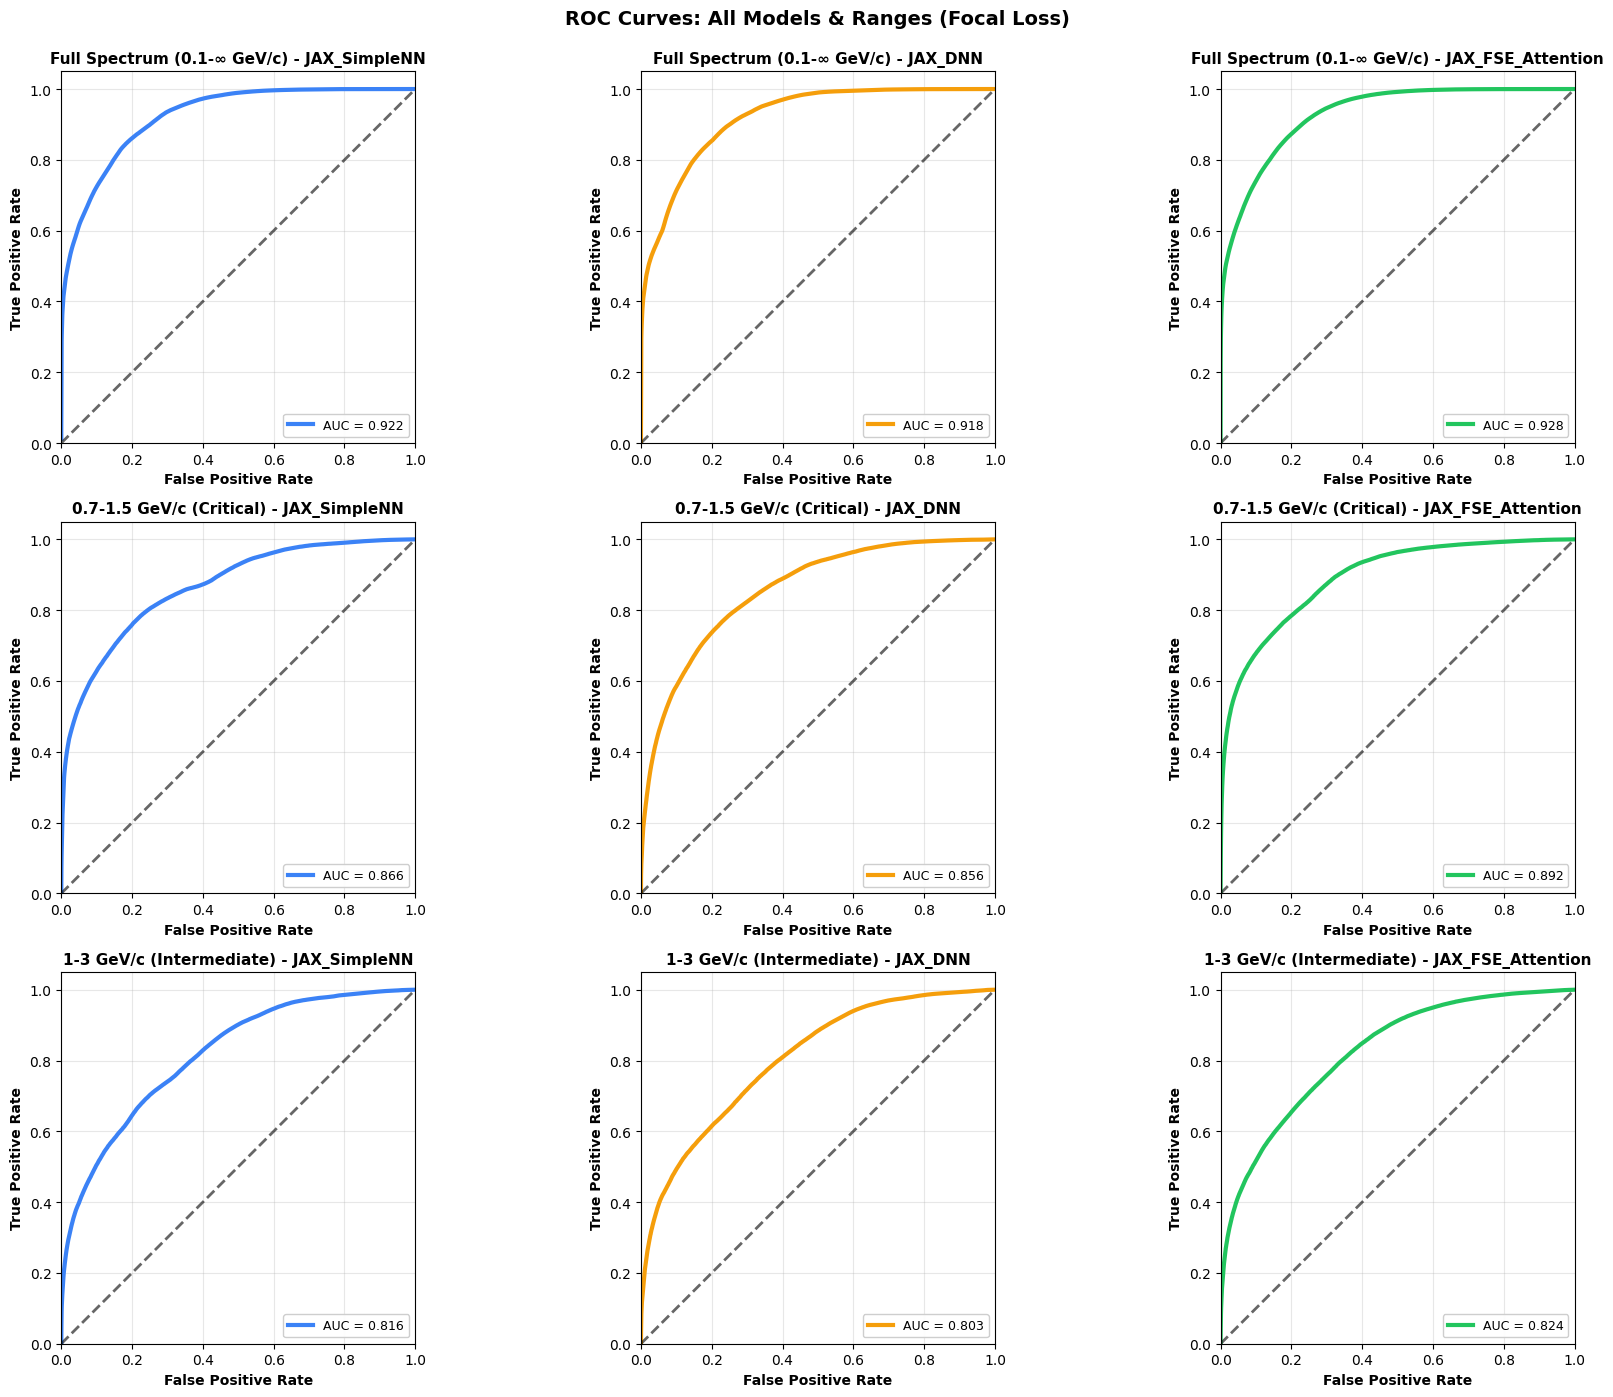

✓ ROC/AUC curves generated

AUC SCORES SUMMARY (All 9 Models)

             Momentum Range             Model   Pion   Kaon Proton Electron Macro-avg Micro-avg
Full Spectrum (0.1-∞ GeV/c)      JAX_SimpleNN 0.8962 0.8872 0.9765   0.9279    0.9219    0.9158
Full Spectrum (0.1-∞ GeV/c)           JAX_DNN 0.8925 0.8805 0.9751   0.9252    0.9183    0.9225
Full Spectrum (0.1-∞ GeV/c) JAX_FSE_Attention 0.9050 0.8938 0.9793   0.9340    0.9280    0.9252
   0.7-1.5 GeV/c (Critical)      JAX_SimpleNN 0.8679 0.6911 0.9564   0.9472    0.8657    0.8790
   0.7-1.5 GeV/c (Critical)           JAX_DNN 0.8727 0.6963 0.9388   0.9152    0.8557    0.8701
   0.7-1.5 GeV/c (Critical) JAX_FSE_Attention 0.8873 0.7574 0.9630   0.9587    0.8916    0.9058
   1-3 GeV/c (Intermediate)      JAX_SimpleNN 0.7747 0.6982 0.8407   0.9499    0.8159    0.8098
   1-3 GeV/c (Intermediate)           JAX_DNN 0.7618 0.6853 0.8224   0.9439    0.8033    0.8080
   1-3 GeV/c (Intermediate) JAX_FSE_Attention 0.7837 0.7119 0.8482   0.95

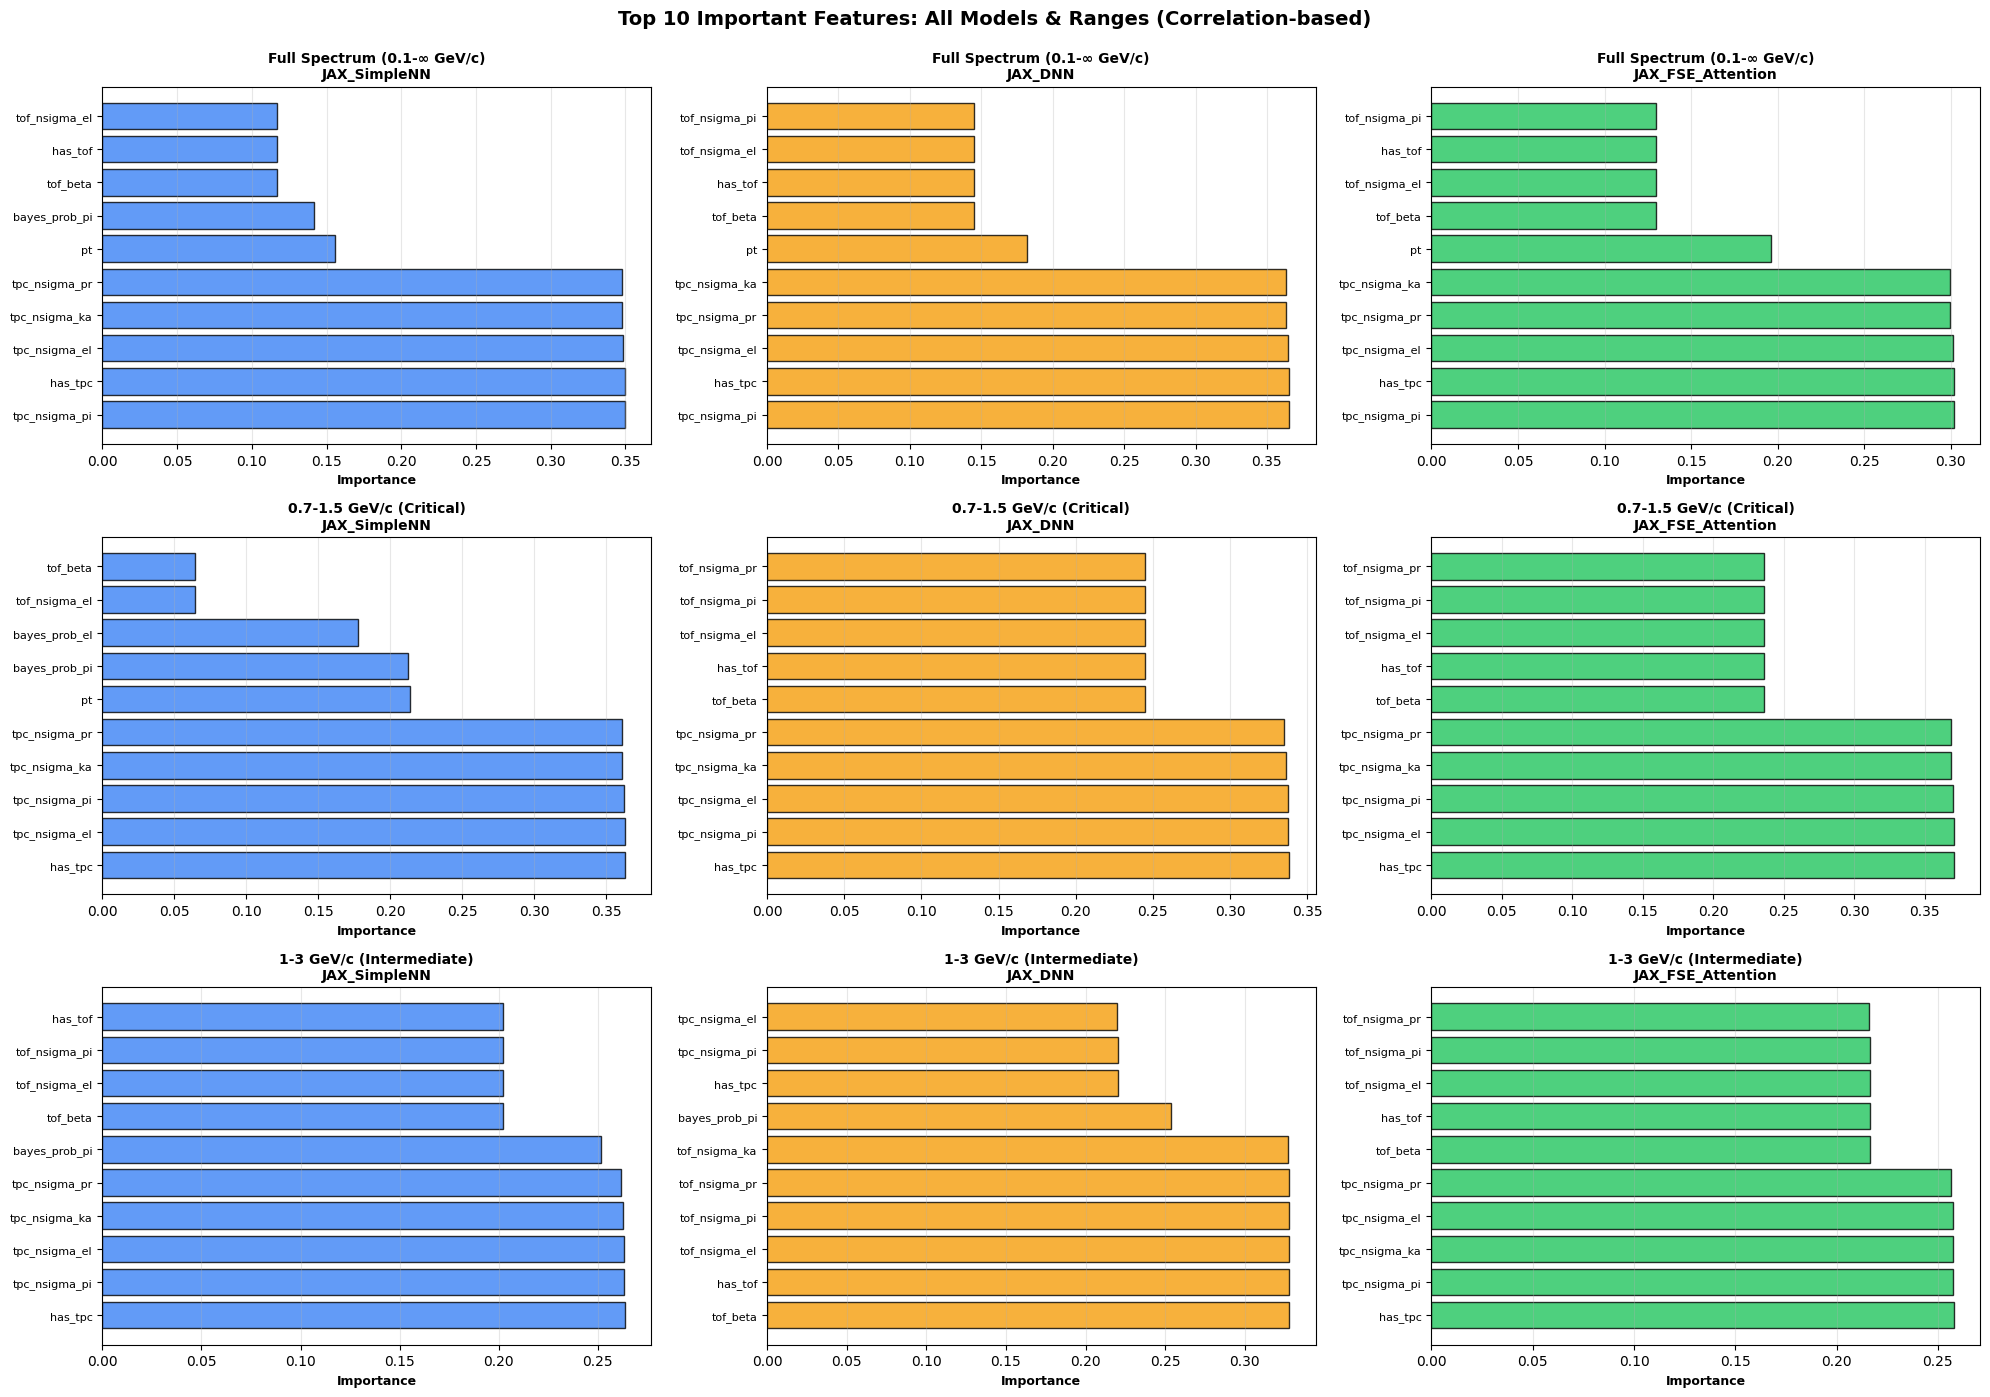

✓ Feature importance plots generated

SUMMARY STATISTICS BY MODEL TYPE


────────────────────────────────────────────────────────────────────────────────
MODEL: JAX_SimpleNN
────────────────────────────────────────────────────────────────────────────────

  Full Spectrum (0.1-∞ GeV/c):
    Train Acc: 0.6139
    Test Acc:  0.6142
    Best Val:  0.6142

  0.7-1.5 GeV/c (Critical):
    Train Acc: 0.6156
    Test Acc:  0.6150
    Best Val:  0.6150

  1-3 GeV/c (Intermediate):
    Train Acc: 0.4937
    Test Acc:  0.4956
    Best Val:  0.4956

────────────────────────────────────────────────────────────────────────────────
MODEL: JAX_DNN
────────────────────────────────────────────────────────────────────────────────

  Full Spectrum (0.1-∞ GeV/c):
    Train Acc: 0.6323
    Test Acc:  0.6326
    Best Val:  0.6326

  0.7-1.5 GeV/c (Critical):
    Train Acc: 0.5900
    Test Acc:  0.5888
    Best Val:  0.5888

  1-3 GeV/c (Intermediate):
    Train Acc: 0.4728
    Test Acc:  0.4740
    Best Val:

In [12]:
# ============================================================================
# SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5B: ROC/AUC CURVES, FEATURE IMPORTANCE & SUMMARY STATISTICS")
print(f"{'#'*80}")

# ============================================================================
# COMPARISON: ROC CURVES - 3 RANGES × 3 MODELS
# ============================================================================

print("\n✓ Generating ROC/AUC curves...")

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

macro_colors = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B',
    'JAX_FSE_Attention': '#22C55E'
}

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_idx, model_type in enumerate(MODEL_TYPES):
        ax = axes[mr_idx, model_idx]
        
        if model_type in mr_data:
            results = mr_data[model_type]
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            
            # Compute macro-average ROC curve and AUC
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(NUM_CLASSES):
                fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Compute macro-average
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(NUM_CLASSES):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= NUM_CLASSES
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            
            # Plot macro-average ROC curve
            ax.plot(fpr["macro"], tpr["macro"],
                   color=macro_colors[model_type], 
                   linewidth=3,
                   label=f'AUC = {roc_auc["macro"]:.3f}')
        
        # Plot diagonal (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6)
        
        # Customise plot
        ax.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
        title = f'{momentum_range["name"]} - {model_type}'
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9, framealpha=0.95)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')

plt.suptitle('ROC Curves: All Models & Ranges (Focal Loss)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ ROC/AUC curves generated")

# ============================================================================
# AUC SCORES SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("AUC SCORES SUMMARY (All 9 Models)")
print(f"{'='*80}\n")

auc_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            
            # Compute AUC for each class
            class_aucs = []
            for i in range(NUM_CLASSES):
                fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
                class_aucs.append(auc(fpr, tpr))
            
            # Compute macro and micro AUC
            macro_auc = np.mean(class_aucs)
            micro_auc = roc_auc_score(
                np.eye(NUM_CLASSES)[y_test], 
                y_score, 
                average='micro'
            )
            
            auc_data.append({
                'Momentum Range': momentum_range['name'],
                'Model': model_type,
                'Pion': f"{class_aucs[0]:.4f}",
                'Kaon': f"{class_aucs[1]:.4f}",
                'Proton': f"{class_aucs[2]:.4f}",
                'Electron': f"{class_aucs[3]:.4f}",
                'Macro-avg': f"{macro_auc:.4f}",
                'Micro-avg': f"{micro_auc:.4f}"
            })

auc_df = pd.DataFrame(auc_data)
print(auc_df.to_string(index=False))
print()

# ============================================================================
# FEATURE IMPORTANCE ANALYSIS: CORRELATION-BASED
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*80}\n")

feature_importance_data = {}

print("Computing feature importance for all models...\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    feature_importance_data[mr_key] = {}
    
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    features = all_results_by_model_and_range[mr_key]['preprocessing']['features']
    
    print(f"  {momentum_range['name']}:")
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            
            # Use correlation-based feature importance
            y_pred = np.array(results['y_pred_test'])
            y_test_arr = np.array(results['y_test'])
            
            # Compute feature importance as correlation with correct predictions
            importances = []
            correct_predictions = (y_pred == y_test_arr).astype(float)
            
            for feature_idx in range(X_test_scaled.shape[1]):
                feature_values = X_test_scaled[:, feature_idx]
                # Correlation between feature values and prediction correctness
                corr_matrix = np.corrcoef(feature_values, correct_predictions)
                correlation = np.abs(corr_matrix[0, 1])
                # Handle NaN values
                if np.isnan(correlation):
                    correlation = 0.0
                importances.append(correlation)
            
            feature_importance_data[mr_key][model_type] = {
                'importances': np.array(importances),
                'features': features
            }
            
            print(f"    ✓ {model_type}: computed")

print(f"\n{'='*80}")

# ============================================================================
# PLOT: FEATURE IMPORTANCE COMPARISON - ALL RANGES & MODELS
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(20, 14))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_idx, model_type in enumerate(MODEL_TYPES):
        ax = axes[mr_idx, model_idx]
        
        if model_type in feature_importance_data[mr_key]:
            imp_dict = feature_importance_data[mr_key][model_type]
            importances = imp_dict['importances']
            features = imp_dict['features']
            
            # Get top 10 features
            top_indices = np.argsort(importances)[-10:][::-1]
            top_features = [features[i] for i in top_indices]
            top_importances = importances[top_indices]
            
            ax.barh(range(len(top_features)), top_importances, 
                   color=model_colors[model_type], alpha=0.8, edgecolor='black')
            
            ax.set_yticks(range(len(top_features)))
            ax.set_yticklabels(top_features, fontsize=8)
            ax.set_xlabel('Importance', fontsize=9, fontweight='bold')
            ax.set_title(f'{momentum_range["name"]}\n{model_type}', fontsize=10, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

plt.suptitle('Top 10 Important Features: All Models & Ranges (Correlation-based)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Feature importance plots generated")

# ============================================================================
# SUMMARY STATISTICS BY MODEL
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS BY MODEL TYPE")
print(f"{'='*80}\n")

for model_type in MODEL_TYPES:
    print(f"\n{'─'*80}")
    print(f"MODEL: {model_type}")
    print(f"{'─'*80}")
    
    for mr_key, mr_data in all_results_by_model_and_range.items():
        momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
        
        if model_type in mr_data:
            results = mr_data[model_type]
            
            print(f"\n  {momentum_range['name']}:")
            print(f"    Train Acc: {results['train_acc']:.4f}")
            print(f"    Test Acc:  {results['test_acc']:.4f}")
            print(f"    Best Val:  {results['best_val_acc']:.4f}")

print(f"\n{'='*80}")
print("OVERALL BEST MODELS (PER MOMENTUM RANGE)")
print(f"{'='*80}\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    best_acc = 0
    best_model = None
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            if results['test_acc'] > best_acc:
                best_acc = results['test_acc']
                best_model = model_type
    
    print(f"{momentum_range['name']:40s}: {best_model:25s} - {best_acc:.4f}")

# ============================================================================
# DIFFICULTY ANALYSIS BY MOMENTUM RANGE
# ============================================================================

print(f"\n{'='*80}")
print("MOMENTUM RANGE DIFFICULTY ANALYSIS")
print(f"{'='*80}\n")

print("Average performance across all models:\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    all_accs = []
    all_aucs = []
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]
            all_accs.append(results['test_acc'])
            
            y_test = np.array(results['y_test'])
            y_score = np.array(results['test_probs'])
            macro_auc = roc_auc_score(np.eye(NUM_CLASSES)[y_test], y_score, average='macro')
            all_aucs.append(macro_auc)
    
    avg_acc = np.mean(all_accs)
    avg_auc = np.mean(all_aucs)
    
    print(f"{momentum_range['name']:40s}:")
    print(f"  Average Accuracy:    {avg_acc:.4f}")
    print(f"  Average Macro-AUC:   {avg_auc:.4f}")
    print(f"  Difficulty Score:    {1-avg_auc:.4f} (lower AUC = more difficult)")
    print()

print(f"\n{'='*80}")
print("✓ SECTION 5B COMPLETE: ROC/AUC, Feature Importance & Summary Statistics")
print(f"{'='*80}")
print(f"\nAll 9 JAX models trained and compared:")
print(f"  ✓ JAX_SimpleNN × 3 momentum ranges = 3 models")
print(f"  ✓ JAX_DNN × 3 momentum ranges = 3 models (with BatchNorm)")
print(f"  ✓ JAX_FSE_Attention × 3 momentum ranges = 3 models (with detector masking)")
print(f"\nTraining Configuration:")
print(f"  ✓ Loss function: Focal Loss (α=0.25, γ=2.0) for all models")
print(f"  ✓ Class weights: Balanced (inverse class frequency)")
print(f"  ✓ Patience: 10 epochs")
print(f"\nVisualizations & Analysis generated:")
print(f"  ✓ Accuracy comparison (3 × 3 grid)")
print(f"  ✓ Training loss curves (3 × 3 grid)")
print(f"  ✓ Validation accuracy curves (3 × 3 grid)")
print(f"  ✓ Confusion matrices (3 best models)")
print(f"  ✓ ROC/AUC curves (3 × 3 grid)")
print(f"  ✓ AUC scores summary table")
print(f"  ✓ Feature importance analysis (3 × 3 grid)")
print(f"  ✓ Summary statistics by model type")
print(f"  ✓ Momentum range difficulty analysis")
print(f"\n{'='*80}\n")
